# MOD09A1 - MODIS/Terra Surface Reflectance 8-Day L3 Global 500m SIN Grid

## Links Used:
* Dataset used: https://catalogue.ceda.ac.uk/uuid/05a18921d3a44c89a9158809fd813eb3?jump=related-docs-anchor
* Guide to dataset: https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/products/MOD09A1#overview
* Guide pdf: https://salsa.umd.edu/files/MOD09_UserGuide_v1.4.pdf
* Understanding modis data and plotting: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/modis-data-in-python/

## Data Used:
\* signs used in the below list denote wildcard indexing.
* archive/neodc/modis/data/MOD09A1/collection6/\*/\*/\*/\*h18v03*
* archive/neodc/modis/data/MOD09A1/collection6/\*/\*/\*/\*h18v04*
* archive/neodc/modis/data/MOD09A1/collection6/\*/\*/\*/\*h19v03*
* archive/neodc/modis/data/MOD09A1/collection6/\*/\*/\*/\*h19v04*

## Prerequisites:
Before being able to run the below code, a suitable conda environment must be set up.
This environment must be set up to handle the modis files, and requires a variety of geospatial modules.
If you already have miniconda set up on your local PC all you need to do is set up the environment from the terminal.
The following code will be of use:
- $ conda create -n modis_env
- $ conda activate modis_env
- $ conda install -c conda-forge rioxarray
- $ conda install ipykernel
- $ conda install matplotlib
- $ conda install -c conda-forge geopandas
- $ conda install -c conda-forge earthpy

In [1]:
import os
import warnings
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping, box
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

## Tile Suitability Testing

Importing the tiles that may be useful to the area we are interested in:
* h18v03
* h18v04
* h19v03
* h19v04 

In [2]:
# Finding the extreme spatial bounds of the modis data.

# archive/neodc/modis/data/MOD09A1/collection6/2009/01/09/
modis_path1 = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/MOD09A1.A2009009.h18v03.006.2015186095829.hdf"
# h18v03 ^
modis_path2 = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/MOD09A1.A2009009.h18v04.006.2015186095816.hdf"
# h18v04 ^
modis_path3 = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/MOD09A1.A2009009.h19v03.006.2015186095607.hdf"
# h19v03 ^
modis_path4 = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/MOD09A1.A2009009.h19v04.006.2015186095704.hdf"
# h19v04 ^

modis_file1 = rxr.open_rasterio(modis_path1, masked=True)
# h18v03 ^
modis_file2 = rxr.open_rasterio(modis_path2, masked=True)
# h18v04 ^
modis_file3 = rxr.open_rasterio(modis_path3, masked=True)
# h19v03 ^
modis_file4 = rxr.open_rasterio(modis_path4, masked=True)
# h19v04 ^

In [3]:
# Printing the bounds from the attributes section of the xarray files.
print("File1 (h18v03) Bounds:")
print(f"N:{modis_file1.attrs['NORTHBOUNDINGCOORDINATE']}")
print(f"E:{modis_file1.attrs['EASTBOUNDINGCOORDINATE']}")
print(f"S:{modis_file1.attrs['SOUTHBOUNDINGCOORDINATE']}")
print(f"W:{modis_file1.attrs['WESTBOUNDINGCOORDINATE']}\n")

print("File2 (h18v04) Bounds:")
print(f"N:{modis_file2.attrs['NORTHBOUNDINGCOORDINATE']}")
print(f"E:{modis_file2.attrs['EASTBOUNDINGCOORDINATE']}")
print(f"S:{modis_file2.attrs['SOUTHBOUNDINGCOORDINATE']}")
print(f"W:{modis_file2.attrs['WESTBOUNDINGCOORDINATE']}\n")

print("File3 (h19v03) Bounds:")
print(f"N:{modis_file3.attrs['NORTHBOUNDINGCOORDINATE']}")
print(f"E:{modis_file3.attrs['EASTBOUNDINGCOORDINATE']}")
print(f"S:{modis_file3.attrs['SOUTHBOUNDINGCOORDINATE']}")
print(f"W:{modis_file3.attrs['WESTBOUNDINGCOORDINATE']}\n")

print("File4 (h19v04) Bounds:")
print(f"N:{modis_file4.attrs['NORTHBOUNDINGCOORDINATE']}")
print(f"E:{modis_file4.attrs['EASTBOUNDINGCOORDINATE']}")
print(f"S:{modis_file4.attrs['SOUTHBOUNDINGCOORDINATE']}")
print(f"W:{modis_file4.attrs['WESTBOUNDINGCOORDINATE']}\n")

# Setting up WSEN bound arrays for each of the files.
file1_wsen = np.array([modis_file1.attrs['WESTBOUNDINGCOORDINATE'], modis_file1.attrs['SOUTHBOUNDINGCOORDINATE'], 
                        modis_file1.attrs['EASTBOUNDINGCOORDINATE'], modis_file1.attrs['NORTHBOUNDINGCOORDINATE']])
file2_wsen = np.array([modis_file2.attrs['WESTBOUNDINGCOORDINATE'], modis_file2.attrs['SOUTHBOUNDINGCOORDINATE'], 
                        modis_file2.attrs['EASTBOUNDINGCOORDINATE'], modis_file2.attrs['NORTHBOUNDINGCOORDINATE']])
file3_wsen = np.array([modis_file3.attrs['WESTBOUNDINGCOORDINATE'], modis_file3.attrs['SOUTHBOUNDINGCOORDINATE'], 
                        modis_file3.attrs['EASTBOUNDINGCOORDINATE'], modis_file3.attrs['NORTHBOUNDINGCOORDINATE']])
file4_wsen = np.array([modis_file4.attrs['WESTBOUNDINGCOORDINATE'], modis_file4.attrs['SOUTHBOUNDINGCOORDINATE'], 
                        modis_file4.attrs['EASTBOUNDINGCOORDINATE'], modis_file4.attrs['NORTHBOUNDINGCOORDINATE']])

File1 (h18v03) Bounds:
N:59.9999999946118
E:20.0166666616087
S:49.9999999955098
W:0.0

File2 (h18v04) Bounds:
N:49.9999999955098
E:15.5702026309755
S:39.9999999964079
W:0.0

File3 (h19v03) Bounds:
N:59.9999999946118
E:40.016666656555
S:49.9999999955098
W:15.5572382657541

File4 (h19v04) Bounds:
N:49.9999999955098
E:31.1274408967296
S:39.9999999964079
W:13.0540728914638



We will now find the extent of the project area by looking at our original shape files.

In [4]:
# Finding the extreme spatial bounds of the project area.
shp_plot_locations = gpd.read_file('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/ShapeFiles/whole_map.shp')
project_wsen = shp_plot_locations.total_bounds

print(f"Project Bounds:")
print(f"N:{shp_plot_locations.total_bounds[3]}")
print(f"E:{shp_plot_locations.total_bounds[2]}")
print(f"S:{shp_plot_locations.total_bounds[1]}")
print(f"W:{shp_plot_locations.total_bounds[0]}")

Project Bounds:
N:53.04445372901561
E:32.10002856023667
S:50.50148427738854
W:22.944695970820717


Now we will compare the project area against the bounds we found for each of the tiles we suspect as being of use. Hopefully one of the tiles will encompass the entirety of the area we require, which would mean we don't have to stitch any tiles together during processing.

In [5]:
def tile_suitability_checker(tile_bounds, project_bounds):
    """
    A function that checks the suitability of tiles geospatially.
    Takes in the tiles bounds and the projects overall bounds.
    Returns the suitability of a given tile.
    """
    i = 0
    west_check = 0
    south_check = 0
    east_check = 0
    north_check = 0
    for _,__ in zip(tile_bounds, project_bounds):
        if i == 0:
            if _ < __:
                west_check = 1
        if i == 1:
            if _ < __:
                south_check = 1
        if i == 2:
            if _ > __:
                east_check = 1
        if i == 3:
            if _ > __:
                north_check = 1
        i += 1
    
    if west_check + south_check + east_check + north_check == 4:
        return("Tile suitable")
    else:
        return("Tile unsuitable")

print(f"File1 (h18v03): {tile_suitability_checker(file1_wsen, project_wsen)}")
print(f"File2 (h18v04): {tile_suitability_checker(file2_wsen, project_wsen)}")
print(f"File3 (h19v03): {tile_suitability_checker(file3_wsen, project_wsen)}")
print(f"File4 (h19v04): {tile_suitability_checker(file4_wsen, project_wsen)}")

File1 (h18v03): Tile unsuitable
File2 (h18v04): Tile unsuitable
File3 (h19v03): Tile suitable
File4 (h19v04): Tile unsuitable


## Tile Cropping

Having found tile3, aka h19v03 to be suitably encompassing of the entire study area, we will now pursue the cropping of the data to the correct spatial bounds, before looking at the overarching download and filing system we may need to design next.

In [6]:
# The desired bands of 2 and 6 are specified; these are used to calculate ndmi later.
desired_bands = ["sur_refl_b02", "sur_refl_b06"]
modis_bands_pre = rxr.open_rasterio(modis_path3, masked=True, variable=desired_bands)
modis_bands_pre

<xarray.Dataset>
Dimensions:       (y: 2400, x: 2400, band: 1)
Coordinates:
  * y             (y) float64 6.671e+06 6.671e+06 ... 5.56e+06 5.56e+06
  * x             (x) float64 1.112e+06 1.113e+06 ... 2.223e+06 2.224e+06
  * band          (band) int64 1
    spatial_ref   int64 0
Data variables:
    sur_refl_b02  (band, y, x) float32 ...
    sur_refl_b06  (band, y, x) float32 ...
Attributes: (12/174)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    AUTOMATICQUALITYFLAG.1:             Passed
    AUTOMATICQUALITYFLAGEXPLANATION.1:  Always Passed
    CHARACTERISTICBINANGULARSIZE250M:   7.5
    ...                                 ...
    SPSOPARAMETERS:                     2015
    SYSTEMFILENAME:                     MOD09GQ.A2009009.h19v03.006.201518606...
    TileID:                             51019003
    VERSIONID:                          6
    VERTICALTILENUMBER:                 3
    WESTBOUNDINGCOORDINATE:             15.5572382657541

In [7]:
# Some script that trims the bounds of tiles is trialled.
# The path to the shape file defining the outer bounds of the project area is defined.
project_area_boundary_path = os.path.join("/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/ShapeFiles/whole_map.shp")
# geopandas reads in the boudary from the shaoe files.
project_area_boundary = gpd.read_file(project_area_boundary_path)
# An exact clipped area is made below:
project_area_sin = project_area_boundary.to_crs(modis_bands_pre.rio.crs)
# A maximum extent box area is made below:
project_area_bound_box = [box(*project_area_sin.total_bounds)]

# The two different cropping methods are setup below:
modis_clip_geometry = modis_bands_pre.rio.clip(project_area_sin.geometry, all_touched=True, from_disk=True)
modis_clip = modis_bands_pre.rio.clip(project_area_bound_box, all_touched=True, from_disk=True)

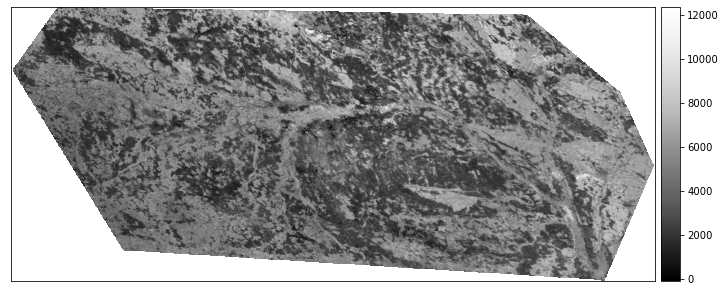

In [8]:
# Exact trim cropping plot:
ep.plot_bands(modis_clip_geometry.sur_refl_b02)
plt.show()

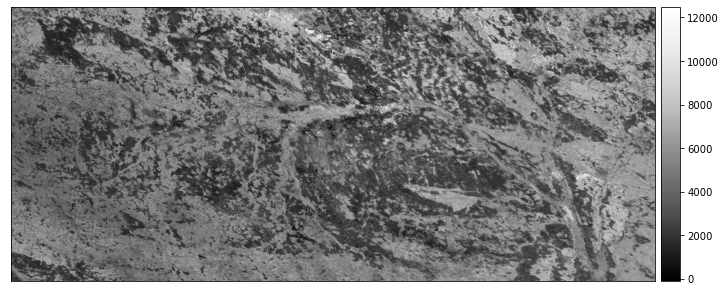

In [9]:
# Rough trim cropping plot:
ep.plot_bands(modis_clip.sur_refl_b02)
plt.show()

## Tile Compilation

In [10]:
directory = '/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/pre-downloaded/h19v03'

def path_assigner(directory):
    i = 0
    path_array = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        path_array.append(f)
        i += 1
    return(path_array)

# Assign paths for the files in the directory.
path_array = path_assigner(directory)

In [11]:
def tile_opener(path_array, desired_bands):
    file_array = []
    for path in path_array:
        file_array.append(rxr.open_rasterio(path, masked=True, variable=desired_bands))
    return(file_array)

desired_bands = ["sur_refl_b02", "sur_refl_b06"]
file_array = tile_opener(path_array, desired_bands)

In [12]:
project_area_boundary_path = "/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/ndmi_pre-processing/modis_downloading_testing/ShapeFiles/whole_map.shp"
project_area_boundary = gpd.read_file(project_area_boundary_path)
project_area_sin = project_area_boundary.to_crs(file_array[0].rio.crs)
project_area_bound_box = [box(*project_area_sin.total_bounds)]

def rough_cropper(file_array, project_area_bound_box):
    cropd_file_array = []
    for _ in file_array:
        cropd_file_array.append(_.rio.clip(project_area_bound_box, all_touched=True, from_disk=True))
    return cropd_file_array

cropd_file_array = rough_cropper(file_array, project_area_bound_box)

### Averaging across the month

In [19]:
cropd_file_array[0]

<xarray.Dataset>
Dimensions:       (y: 611, x: 1434, band: 1)
Coordinates:
  * y             (y) float64 5.898e+06 5.898e+06 ... 5.616e+06 5.616e+06
  * x             (x) float64 1.555e+06 1.555e+06 ... 2.218e+06 2.219e+06
  * band          (band) int64 1
    spatial_ref   int64 0
Data variables:
    sur_refl_b02  (band, y, x) float32 4.889e+03 3.347e+03 ... 6.479e+03
    sur_refl_b06  (band, y, x) float32 774.0 815.0 959.0 ... 3.954e+03 4.168e+03
Attributes: (12/182)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    AUTOMATICQUALITYFLAG.1:             Passed
    AUTOMATICQUALITYFLAGEXPLANATION.1:  Always Passed
    CHARACTERISTICBINANGULARSIZE250M:   7.5
    ...                                 ...
    SPSOPARAMETERS:                     2015
    SYSTEMFILENAME:                     MOD09GQ.A2009017.h19v03.006.201518605...
    TileID:                             51019003
    VERSIONID:                          6
    VERTICALTILENUMBER:                 3
    WESTBOUNDINGCOORDINATE:             15.5572382657541

In [20]:
print("The maximum value in sur_refl_b06 is:")
print(np.nanmax(np.array(cropd_file_array[0].sur_refl_b06.values).reshape(-1, 1)))
print("The minimum value in sur_refl_b06 is:")
print(np.nanmin(np.array(cropd_file_array[0].sur_refl_b06.values).reshape(-1, 1)))
print("The NaN count in sur_refl_b06 is:")
print(np.count_nonzero(np.isnan(np.array(cropd_file_array[0].sur_refl_b06.values).reshape(-1, 1))))
print("The non-NaN count in sur_refl_b06 is:")
print(np.count_nonzero(~np.isnan(np.array(cropd_file_array[0].sur_refl_b06.values).reshape(-1, 1))))
print("\nThe maximum value in sur_refl_b02 is:")
print(np.nanmax(np.array(cropd_file_array[0].sur_refl_b02.values).reshape(-1, 1)))
print("The minimum value in sur_refl_b02 is:")
print(np.nanmin(np.array(cropd_file_array[0].sur_refl_b02.values).reshape(-1, 1)))
print("The NaN count in sur_refl_b02 is:")
print(np.count_nonzero(np.isnan(np.array(cropd_file_array[0].sur_refl_b02.values).reshape(-1, 1))))
print("The non-NaN count in sur_refl_b02 is:")
print(np.count_nonzero(~np.isnan(np.array(cropd_file_array[0].sur_refl_b02.values).reshape(-1, 1))))

The maximum value in sur_refl_b06 is:
11379.0
The minimum value in sur_refl_b06 is:
-100.0
The NaN count in sur_refl_b06 is:
0
The non-NaN count in sur_refl_b06 is:
876174

The maximum value in sur_refl_b02 is:
13542.0
The minimum value in sur_refl_b02 is:
-100.0
The NaN count in sur_refl_b02 is:
0
The non-NaN count in sur_refl_b02 is:
876174


In [21]:
averaged_file = cropd_file_array[0].assign(sur_refl_b02_avg=xr.full_like(cropd_file_array[0].sur_refl_b02, 5000))
averaged_file = averaged_file.assign(sur_refl_b06_avg=xr.full_like(cropd_file_array[0].sur_refl_b06, 5000))
averaged_file = averaged_file.drop(labels=["sur_refl_b02","sur_refl_b06"])
averaged_file

<xarray.Dataset>
Dimensions:           (y: 611, x: 1434, band: 1)
Coordinates:
  * y                 (y) float64 5.898e+06 5.898e+06 ... 5.616e+06 5.616e+06
  * x                 (x) float64 1.555e+06 1.555e+06 ... 2.218e+06 2.219e+06
  * band              (band) int64 1
    spatial_ref       int64 0
Data variables:
    sur_refl_b02_avg  (band, y, x) float32 5e+03 5e+03 5e+03 ... 5e+03 5e+03
    sur_refl_b06_avg  (band, y, x) float32 5e+03 5e+03 5e+03 ... 5e+03 5e+03
Attributes: (12/182)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    AUTOMATICQUALITYFLAG.1:             Passed
    AUTOMATICQUALITYFLAGEXPLANATION.1:  Always Passed
    CHARACTERISTICBINANGULARSIZE250M:   7.5
    ...                                 ...
    SPSOPARAMETERS:                     2015
    SYSTEMFILENAME:                     MOD09GQ.A2009017.h19v03.006.201518605...
    TileID:                             51019003
    VERSIONID:                          6
    VERTICALTILENUMBER:                 3
    WESTBOUNDINGCOORDINATE:             15.5572382657541

In [22]:
i = 0
for _ in averaged_file.y.values:
    j = 0
    for __ in averaged_file.x.values:
        b2_vals = []
        b6_vals = []
        for ___ in file_array:
            b2_vals.append(___.sur_refl_b02.values[0, j, i])
            b6_vals.append(___.sur_refl_b06.values[0, j, i])
        b2_average_val = sum(b2_vals) / len(b2_vals)
        b6_average_val = sum(b6_vals) / len(b6_vals)
        print(f"{b2_average_val}, {b6_average_val}\n")
        j += 1
    i += 1

1522.3333333333333, 1435.6666666666667

4320.0, 4196.333333333333

1899.3333333333333, 1667.3333333333333

1484.0, 1433.0

4572.0, 4300.333333333333

1329.6666666666667, 1337.3333333333333

1440.3333333333333, 1441.0

3872.6666666666665, 4017.6666666666665

1546.6666666666667, 1515.3333333333333

1187.3333333333333, 1190.3333333333333

1157.3333333333333, 1094.0

1003.3333333333334, 954.3333333333334

1847.0, 2044.0

1098.6666666666667, 1051.6666666666667

1114.0, 1080.6666666666667

1663.0, 1363.6666666666667

1210.0, 1214.0

1034.6666666666667, 1047.3333333333333

1033.6666666666667, 1041.3333333333333

1218.3333333333333, 1201.6666666666667

1087.3333333333333, 1134.3333333333333

1128.6666666666667, 1151.6666666666667

1128.0, 1176.0

1128.0, 1177.6666666666667

1072.6666666666667, 1121.3333333333333

1131.0, 1161.6666666666667

928.6666666666666, 953.3333333333334

938.6666666666666, 960.0

901.6666666666666, 937.6666666666666

837.6666666666666, 887.6666666666666

1035.3333333333

KeyboardInterrupt: 